# ring model for SSD

In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.signal import resample
import matplotlib.pyplot as plt
import pandas as pd
import importlib

from C_module_interface import gill_ring_sim
from plot_module import plot_ODE, plot_gillespie

In [2]:
# ode model of SSD in neurons
def neuron_model(t, z):
    r0_w, r0_m, r1_w, r1_m, r2_w, r2_m, r3_w, r3_m, r4_w, r4_m, r5_w, r5_m, = z
    
    # birth reactions
    b_r0_w = MU + C_B*(NSS_S-r0_w-r0_m*DELTA) 
    b_r0_m = MU + C_B*(NSS_S-r0_w-r0_m*DELTA)
    b_r1_w = MU + C_B*(NSS_S-r1_w-r1_m*DELTA) 
    b_r1_m = MU + C_B*(NSS_S-r1_w-r1_m*DELTA)
    b_r2_w = MU + C_B*(NSS_S-r2_w-r2_m*DELTA) 
    b_r2_m = MU + C_B*(NSS_S-r2_w-r2_m*DELTA)
    b_r3_w = MU + C_B*(NSS_S-r3_w-r3_m*DELTA) 
    b_r3_m = MU + C_B*(NSS_S-r3_w-r3_m*DELTA)
    b_r4_w = MU + C_B*(NSS_S-r4_w-r4_m*DELTA) 
    b_r4_m = MU + C_B*(NSS_S-r4_w-r4_m*DELTA)
    b_r5_w = MU + C_B*(NSS_S-r5_w-r5_m*DELTA) 
    b_r5_m = MU + C_B*(NSS_S-r5_w-r5_m*DELTA)
    
    return [r0_w*(b_r0_w-GAMMA-MU) + r5_w*GAMMA, 
            r0_m*(b_r0_m-GAMMA-MU) + r5_m*GAMMA, 
            r1_w*(b_r1_w-MU-GAMMA) + r0_w*(GAMMA),
            r1_m*(b_r1_w-MU-GAMMA) + r0_m*(GAMMA),
            r2_w*(b_r2_w-MU-GAMMA) + r1_w*(GAMMA),
            r2_m*(b_r2_w-MU-GAMMA) + r1_m*(GAMMA),
            r3_w*(b_r3_w-MU-GAMMA) + r2_w*(GAMMA),
            r3_m*(b_r3_w-MU-GAMMA) + r2_m*(GAMMA),
            r4_w*(b_r4_w-MU-GAMMA) + r3_w*(GAMMA),
            r4_m*(b_r4_w-MU-GAMMA) + r3_m*(GAMMA),
            r5_w*(b_r5_w-MU-GAMMA) + r4_w*(GAMMA),
            r5_m*(b_r5_w-MU-GAMMA) + r4_m*(GAMMA),
           ]

### Parameters of the simulation

In [3]:
## BIOLOGICAL PARAMETERS ##
MU = 0.07 # death rate
GAMMA = 0.05 # transport rate
DELTA = 0.5 # mutant deficiency
C_B = 0.1 # birth adaptibility constant
NSS_S = 200 # soma carrying capacity

## VARIABLE NAMES ##
VARS = ['so wt', 'so mt', 
        'r1 wt', 'r1 mt',
        'r2 wt', 'r2 mt',
        'r3 wt', 'r3 mt',
        'r4 wt', 'r4 mt',
        'r5 wt', 'r5 mt'
       ]

## COMPONENT NAMES ##
COMP = ['r0','r1','r2','r3','r4','r5',]

## SIMULATION PARAMETERS ##
MAX_T = 5000
TIME_POINTS = np.linspace(0, MAX_T, 500)
start_state = np.array([190, 20, 190, 20, 190, 20, 190, 20, 190, 20, 190, 20], dtype = np.int64)

## Deterministic simulation

In [4]:
sol = integrate.solve_ivp(neuron_model, [0, MAX_T], start_state, t_eval=TIME_POINTS, 
                          method = 'LSODA' # eq system is stiff, needs a solver that can handle such cases
                         )

results = sol.y

Final counts of mt and wt in each compartment:
so wt	190.0	
so mt	20.0	
r1 wt	190.0	
r1 mt	20.0	
r2 wt	190.0	
r2 mt	20.0	
r3 wt	190.0	
r3 mt	20.0	
r4 wt	190.0	
r4 mt	20.0	
r5 wt	190.0	
r5 mt	20.0	

Final effective population sizes in each compartment:
r0	200.0	
r1	200.0	
r2	200.0	
r3	200.0	
r4	200.0	
r5	200.0	


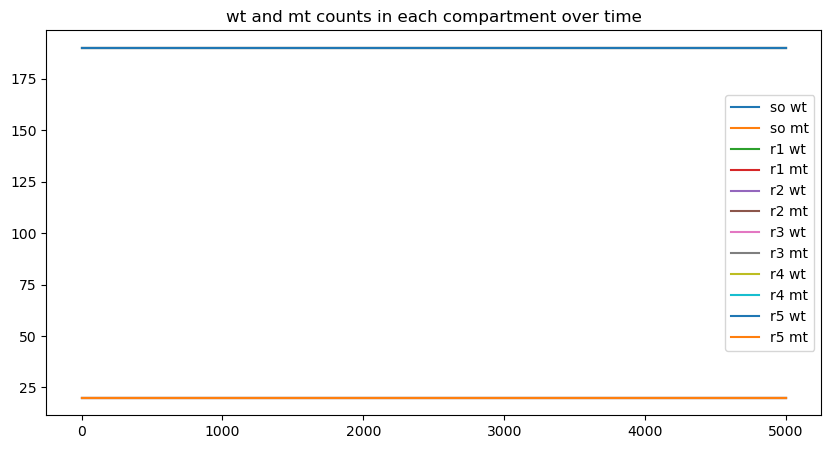

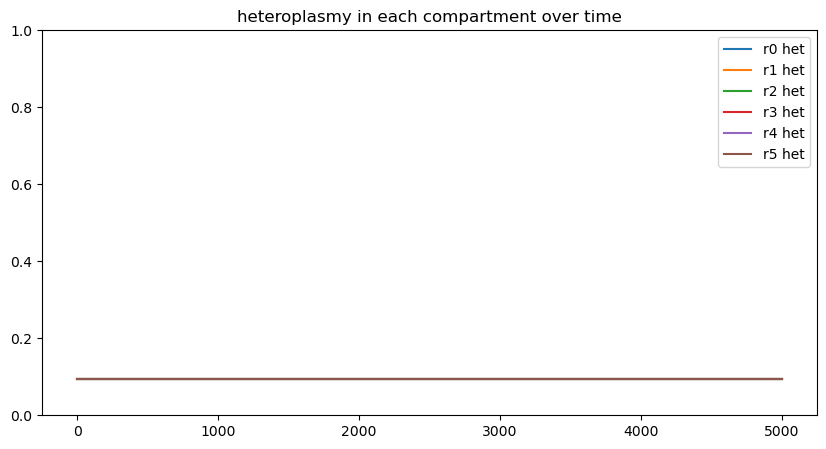

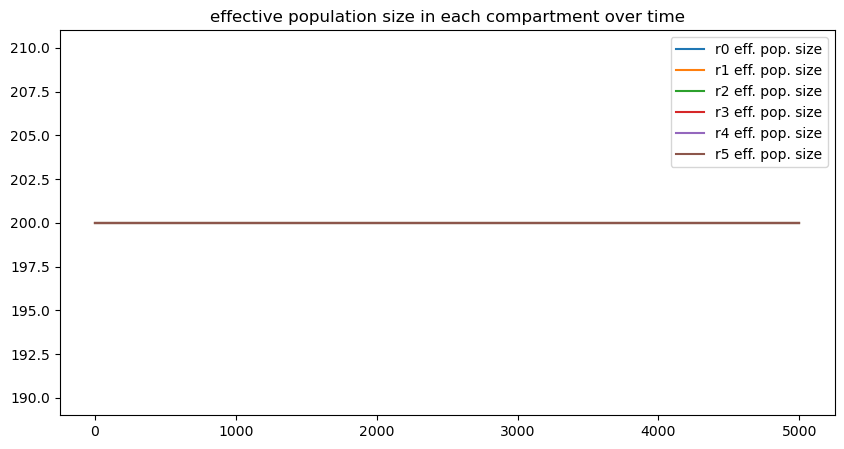

In [5]:
plot_ODE(results, TIME_POINTS, DELTA, VARS, COMP)

In [6]:
## Pooled results from Gillespie based simulation

REPLICATES = 1000
replicate_results = np.zeros((REPLICATES, len(VARS), TIME_POINTS.size), dtype = np.int64)

print('simulating...')
for i in range(REPLICATES):
    replicate_results[i, :, :] = np.swapaxes(gill_ring_sim(MU, GAMMA, DELTA, C_B, NSS_S, TIME_POINTS, start_state), 0, 1)
    print(f"{round(((i+1)/REPLICATES)*100, 2)}% completed  ", end = "\r")

simulating...


Final mean counts of mt and wt in each compartment:
so wt	133.783	
so mt	133.153	
r1 wt	133.652	
r1 mt	133.382	
r2 wt	133.684	
r2 mt	133.355	
r3 wt	134.006	
r3 mt	132.667	
r4 wt	133.8	
r4 mt	133.158	
r5 wt	133.675	
r5 mt	133.219	

Final mean heteroplasmy in each compartment:
r0	0.4049	
r1	0.406	
r2	0.4057	
r3	0.4037	
r4	0.4047	
r5	0.4053	

Final mean effective population sizes in each compartment:
r0	200.3595	
r1	200.343	
r2	200.3615	
r3	200.3395	
r4	200.379	
r5	200.2845	


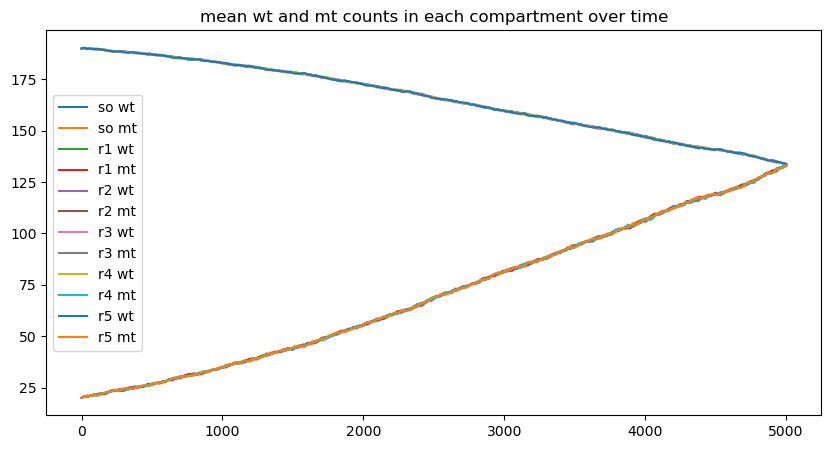

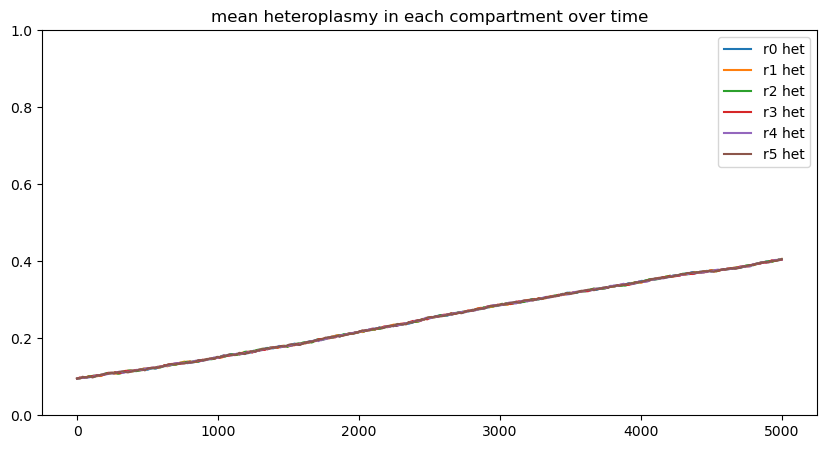

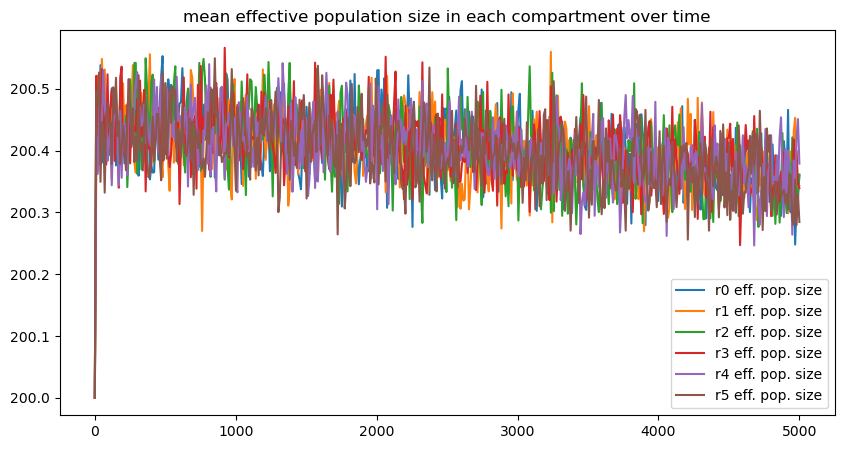

In [7]:
plot_gillespie(replicate_results, TIME_POINTS, DELTA, VARS, COMP)